In [49]:
from dotenv import load_dotenv
load_dotenv()

True

In [50]:
import os

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [51]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(
#     model_name="gpt-4o"
# )

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash"
)

In [52]:
from pydantic import BaseModel, Field
from typing import Optional, List, Dict, Any, Annotated
from langgraph.channels import Topic, LastValue

class TravelAgentState(BaseModel):
    user_query: Annotated[List[str], Topic(str)] = Field(
        default=None, description="User query and any follow-up questions"
    )

    current_place: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Current place of the user"
    )
    destination: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Destination the user wants to go"
    )
    start_date: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Start date of the trip"
    )
    end_date: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="End date of the trip"
    )
    num_days: Annotated[Optional[int], LastValue(int)] = Field(
        default=None, description="Number of days of the trip"
    )
    native_currency: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Native currency of the user"
    )
    budget_range: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Budget range of the trip"
    )
    interests: Annotated[Optional[List[str]], LastValue(List[str])] = Field(
        default=None, description="Interests such as activities, attractions, restaurants, transportation of the user"
    )

    current_weather: Annotated[Optional[Dict[str, Any]], LastValue(Dict[str, Any])] = Field(
        default=None, description="Current weather of the destination"
    )
    weather_forecast: Annotated[Optional[List[Dict[str, Any]]], LastValue(List[Dict[str, Any]])] = Field(
        default=None, description="Weather forecast of the destination"
    )

    attractions: Annotated[Optional[List[Dict[str, Any]]], LastValue(List[Dict[str, Any]])] = Field(
        default=None, description="Attractions of the destination"
    )
    activities: Annotated[Optional[List[Dict[str, Any]]], LastValue(List[Dict[str, Any]])] = Field(
        default=None, description="Activities of the destination"
    )
    restaurants: Annotated[Optional[List[Dict[str, Any]]], LastValue(List[Dict[str, Any]])] = Field(
        default=None, description="Restaurants of the destination"
    )
    transportation_info: Annotated[Optional[Dict[str, Any]], LastValue(Dict[str, Any])] = Field(
        default=None, description="Transportation information of the destination"
    )

    hotel_options: Annotated[Optional[List[Dict[str, Any]]], LastValue(List[Dict[str, Any]])] = Field(
        default=None, description="Hotel options of the destination"
    )
    hotel_cost_per_day: Annotated[Optional[float], LastValue(float)] = Field(
        default=None, description="Hotel cost per day of the destination"
    )
    total_hotel_cost: Annotated[Optional[float], LastValue(float)] = Field(
        default=None, description="Total hotel cost of the destination"
    )

    exchange_currency: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Exchange currency of the destination"
    )
    exchange_rate: Annotated[Optional[float], LastValue(float)] = Field(
        default=None, description="Exchange rate of the destination"
    )
    converted_hotel_cost: Annotated[Optional[float], LastValue(float)] = Field(
        default=None, description="Converted hotel cost of the destination"
    )
    total_trip_cost: Annotated[Optional[float], LastValue(float)] = Field(
        default=None, description="Total trip cost of the destination"
    )
    daily_budget: Annotated[Optional[float], LastValue(float)] = Field(
        default=None, description="Daily budget of the destination"
    )

    daily_plans: Annotated[Optional[List[str]], LastValue(List[str])] = Field(
        default=None, description="Daily plans of the destination"
    )
    full_itinerary: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Full itinerary of the destination"
    )

    summary: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Summary of the destination"
    )
    travel_plan_output: Annotated[Optional[Dict[str, Any]], LastValue(Dict[str, Any])] = Field(
        default=None, description="Travel plan output of the destination"
    )

    validation_errors: Annotated[Optional[List[str]], LastValue(List[str])] = Field(
        default=None, description="Validation errors of the destination"
    )


In [53]:
class UserQuery(BaseModel):
    current_place: Optional[str] = Field(description="Current place of the user")
    destination: Optional[str] = Field(description="Destination the user wants to go")
    start_date: Optional[str] = Field(description="Start date of the trip")
    end_date: Optional[str] = Field(description="End date of the trip")
    num_days: Optional[int] = Field(description="Number of days of the trip")
    interests: Optional[List[str]] = Field(description="Interests of the user")
    native_currency: Optional[str] = Field(description="Native currency of the user")
    budget_range: Optional[str] = Field(description="Budget range of the trip") 

In [54]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from datetime import datetime

def parse_user_query_node(state: TravelAgentState) -> TravelAgentState:
    json_output_parser = JsonOutputParser(pydantic_object=UserQuery)
    format_instructions = json_output_parser.get_format_instructions()

    prompt = PromptTemplate(
        template="""
        You are an intelligent travel agent assistant. Extract and intelligently infer the following fields from the user query.

        Current Date = {current_date}
        
        SMART EXTRACTION RULES:
        1. **Current Place (MUST BE CITY)**:
           - Always extract/convert to a specific city name
           - If country/region given, convert to major city (USA→"New York", UK→"London", France→"Paris")
           - If unclear which city, set to `null` for follow-up

        2. **Destination (FLEXIBLE)**:
           - Can be country, region, or city ("France", "Paris", "Europe", "Tokyo")
           - Keep as user specified - don't force conversion to city

        3. **Currency Intelligence**:
           - Auto-detect from current_place city/country
           - London→GBP, Paris→EUR, New York→USD, Tokyo→JPY, Mumbai→INR

        4. **Interest Intelligence**:
           - Infer from context: "sightseeing"→["attractions"], "food tour"→["restaurants","food"]
           - "museums"→["culture","museums"], "beaches"→["beaches","relaxation"]

        5. **Date & Budget Intelligence**:
           - Parse dates to YYYY-MM-DD format
           - If start_date and num_days provided, calculate end_date automatically
           - Extract budget hints: "cheap"→"budget", "$1000"→"$1000"
           - If budget range given, convert to currency

        EXAMPLES:
        "I'm in London, want to visit France" → current_place: "London", destination: "France", native_currency: "GBP"
        "From California to Japan" → current_place: "Los Angeles", destination: "Japan", native_currency: "USD"
        "From India, going to Europe" → current_place: null (unclear city), destination: "Europe", native_currency: null

        User Query: {query}

        Return a valid JSON object with the format:
        {format_instructions}
        """,
        input_variables=["query"],
        partial_variables={
            "format_instructions": format_instructions, 
            "current_date": datetime.now().strftime("%Y-%m-%d")
        }
    )

    # llm_parser = ChatOpenAI(model="gpt-4o", temperature=0.3)
    llm_parser = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)
    chain = prompt | llm_parser | json_output_parser

    latest_query = state.user_query[-1] if state.user_query else ""
    parsed = chain.invoke(latest_query)

    if parsed.get("current_place"):
        state.current_place = parsed.get("current_place")
    if parsed.get("destination"):
        state.destination = parsed.get("destination")
    if parsed.get("start_date"):
        state.start_date = parsed.get("start_date")
    if parsed.get("end_date"):
        state.end_date = parsed.get("end_date")
    if parsed.get("num_days"):
        state.num_days = parsed.get("num_days")
    if parsed.get("budget_range"):
        state.budget_range = parsed.get("budget_range")
    if parsed.get("interests"):
        state.interests = parsed.get("interests")
    if parsed.get("native_currency"):
        state.native_currency = parsed.get("native_currency")

    return state

In [55]:
def validate_user_query_node(state: TravelAgentState) -> TravelAgentState:
    errors = []
    if state.current_place is None:
        errors.append("Current place is required")
    if state.destination is None:
        errors.append("Destination is required")
    if state.start_date is None:
        errors.append("Start date is required")
    if state.end_date is None:
        errors.append("End date is required")
    if state.num_days is None:
        errors.append("Number of days is required")
    if state.native_currency is None:
        errors.append("Native currency is required")
    if state.budget_range is None:
        errors.append("Budget range is required")
    if state.interests is None:
        errors.append("Interests are required")

    state.validation_errors = errors
    return state

In [56]:
from langchain_core.messages import HumanMessage


def generate_followup_question(errors: list[str]) -> str:
    joined = ", ".join(errors)
    instruction = (
    f"""
    The user did not provide the following information: {joined}.
    Frame a polite, natural-sounding question asking the user to provide these missing details in one response.
    """
    )
    # llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    llm_parser = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)
    response = llm_parser.invoke([HumanMessage(content=instruction)])
    return response.content

In [57]:
def follow_up_user_query_node(state: TravelAgentState) -> TravelAgentState:
    question = generate_followup_question(state.validation_errors)
    print("\nAssistant:", question)

    user_response = input("You: ")
    state.user_query.append(user_response)
    
    json_output_parser = JsonOutputParser(pydantic_object=UserQuery)
    format_instructions = json_output_parser.get_format_instructions()

    prompt = PromptTemplate(
        template="""
        You are an intelligent travel agent assistant. Extract and intelligently infer the following fields from the user input.

        Current Date = {current_date}
        
        SMART EXTRACTION RULES:
        1. **Current Place (MUST BE CITY)**:
           - Always extract/convert to a specific city name
           - If unclear which city, set to `null` for follow-up

        2. **Destination (FLEXIBLE)**:
           - Can be country, region, or city

        3. **Currency Intelligence**:
           - Auto-detect from current_place city/country

        4. **Interest Intelligence**:
           - Infer from context: "sightseeing"→["attractions"], "food tour"→["restaurants","food"]

        5. **Date & Budget Intelligence**:
           - Parse dates to YYYY-MM-DD format
           - If start_date and num_days provided, calculate end_date

        EXAMPLES:
        "I'm in London, want to visit France" → current_place: "London", destination: "France", native_currency: "GBP"
        "From California to Japan" → current_place: "Los Angeles", destination: "Japan", native_currency: "USD"

        User Response: {query}

        Return a valid JSON object with the format:
        {format_instructions}
        """,
        input_variables=["query"],
        partial_variables={
            "format_instructions": format_instructions, 
            "current_date": datetime.now().strftime("%Y-%m-%d")
        }
    )

    # llm_parser = ChatOpenAI(model="gpt-4o", temperature=0.3)
    llm_parser = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)
    chain = prompt | llm_parser | json_output_parser

    parsed = chain.invoke({"query": user_response})

    if parsed.get("current_place"):
        state.current_place = parsed.get("current_place")
    if parsed.get("destination"):
        state.destination = parsed.get("destination")
    if parsed.get("start_date"):
        state.start_date = parsed.get("start_date")
    if parsed.get("end_date"):
        state.end_date = parsed.get("end_date")
    if parsed.get("num_days"):
        state.num_days = parsed.get("num_days")
    if parsed.get("budget_range"):
        state.budget_range = parsed.get("budget_range")
    if parsed.get("interests"):
        state.interests = parsed.get("interests")
    if parsed.get("native_currency"):
        state.native_currency = parsed.get("native_currency")

    return state

In [58]:
def check_if_complete(state: TravelAgentState) -> str:
    if not state.validation_errors:
        return "gather_weather_forecast"
    return "follow_up_user_query"

In [59]:
import os
import requests
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date

OPENWEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")

def gather_weather_forecast_node(state: TravelAgentState) -> TravelAgentState:
    if not state.destination:
        state.validation_errors = state.validation_errors or []
        state.validation_errors.append("Missing destination for weather forecast.")
        return state

    if not state.start_date:
        state.validation_errors = state.validation_errors or []
        state.validation_errors.append("Missing start date for weather forecast.")
        return state

    try:
        start_date = parse_date(state.start_date).date()
    except Exception:
        state.validation_errors = state.validation_errors or []
        state.validation_errors.append("Invalid start_date format.")
        return state

    base_url = "http://api.openweathermap.org/data/2.5"
    location = state.destination
    current_url = f"{base_url}/weather?q={location}&appid={OPENWEATHER_API_KEY}&units=metric"
    forecast_url = f"{base_url}/forecast?q={location}&appid={OPENWEATHER_API_KEY}&units=metric"

    current_res = requests.get(current_url)
    forecast_res = requests.get(forecast_url)

    if current_res.status_code != 200 or forecast_res.status_code != 200:
        state.validation_errors = state.validation_errors or []
        state.validation_errors.append("Failed to fetch weather data. Check destination or API key.")
        return state

    current_data = current_res.json()
    forecast_data = forecast_res.json()

    state.current_weather = {
        "location": current_data["name"],
        "temperature_celsius": current_data["main"]["temp"],
        "condition": current_data["weather"][0]["description"],
        "humidity": current_data["main"]["humidity"],
        "wind_kph": round(current_data["wind"]["speed"] * 3.6, 2)
    }

    forecast_map = {}
    for item in forecast_data["list"]:
        dt_txt = item["dt_txt"]
        if "12:00:00" in dt_txt:
            date = datetime.strptime(dt_txt, "%Y-%m-%d %H:%M:%S").date()
            forecast_map[date] = {
                "date": str(date),
                "condition": item["weather"][0]["description"],
                "temperature": item["main"]["temp"]
            }

    forecast_days = []
    for i in range(state.num_days or 0):
        target_date = start_date + timedelta(days=i)
        forecast = forecast_map.get(target_date, {
            "date": str(target_date),
            "condition": None,
            "temperature": None
        })
        forecast_days.append(forecast)

    state.weather_forecast = forecast_days
    return state

In [60]:
class AttractionsActivitiesResponse(BaseModel):
    attractions: Optional[List[Dict[str, Any]]] = Field(
        default=None,
        description="List of attractions scheduled per day. Each item must include: name, description, location, date (YYYY-MM-DD), and optional duration_hours."
    )
    activities: Optional[List[Dict[str, Any]]] = Field(
        default=None,
        description="List of activities scheduled per day. Each item must include: name, description, location, date (YYYY-MM-DD), and optional duration_hours."
    )

In [61]:
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableSequence
import json

def get_attractions_and_activities_node(state: TravelAgentState) -> TravelAgentState:
    json_output_parser = JsonOutputParser(pydantic_object=AttractionsActivitiesResponse)
    format_instructions = json_output_parser.get_format_instructions()

    user_context = f"""
        User Travel Preferences:
        - Start Date: {state.start_date}
        - End Date: {state.end_date}
        - Number of Days: {state.num_days}
        - Native Currency: {state.native_currency}
        - Budget: {state.budget_range}
        - Interests: {', '.join(state.interests or [])}
        - Destination: {state.destination}

        Weather Forecast for the Trip:
        {json.dumps(state.weather_forecast, indent=2)}
        """

    prompt = PromptTemplate.from_template("""
        You are a smart travel planning assistant. Plan a culturally rich and enjoyable trip to {destination}, customized for the user based on their interests, duration, budget, and the weather forecast.

        Create a daily itinerary spread across {num_days} days (from {start_date} to {end_date}), combining:
        - Attractions: sightseeing, cultural or historical places
        - Activities: interactive experiences, classes, tours, etc.

        Guidelines:
        - Recommend 1–2 meaningful experiences per day.
        - Use weather info to avoid outdoor activities on rainy or overcast days.
        - Spread out high-cost experiences to stay within the budget.
        - Include fields: `name`, `description`, `location`, `date` (YYYY-MM-DD), and optional `duration_hours`.

        Return only VALID JSON (no text, no markdown). Follow this schema:
        {format_instructions}
        """).partial(
                destination=state.destination,
                num_days=state.num_days,
                start_date=state.start_date,
                end_date=state.end_date,
                format_instructions=format_instructions
            )

    # llm = ChatOpenAI(model="gpt-4o", temperature=0.3)
    llm_parser = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)

    chain: RunnableSequence = prompt | llm_parser | json_output_parser

    try:
        attractions_activities = chain.invoke({"input": user_context})
    except Exception as e:
        print("GPT output parsing failed:", e)
        raise

    state.attractions = attractions_activities.get("attractions", [])
    state.activities = attractions_activities.get("activities", [])
    
    return state

In [62]:
class HotelOptionsResponse(BaseModel):
    hotel_options: Optional[List[Dict[str, Any]]] = Field(
        default=None,
        description="Hotel options of the destination, each with name, description, location, price_per_night"
    )
    hotel_cost_per_day: Optional[float] = Field(
        default=None,
        description="Average hotel cost per day"
    )
    total_hotel_cost: Optional[float] = Field(
        default=None,
        description="Total hotel cost over the duration of the trip"
    )

In [63]:
def get_hotels_node(state: TravelAgentState) -> TravelAgentState:
    
    json_output_parser = JsonOutputParser(pydantic_object=HotelOptionsResponse)
    format_instructions = json_output_parser.get_format_instructions()

    user_context = f"""
        User Travel Information:
        - Destination: {state.destination}
        - Start Date: {state.start_date}
        - End Date: {state.end_date}
        - Number of Days: {state.num_days}
        - Native Currency: {state.native_currency}
        - Budget: {state.budget_range}
        """

    prompt = PromptTemplate.from_template("""
    You are a travel assistant using the Tavily Search API to recommend hotel options in {destination}.

    Instructions:
    - Suggest 3 to 5 good-value hotel options that are safe and well-rated.
    - Ensure the total hotel cost fits reasonably within the budget of {budget}.
    - Return price per night and compute total cost based on {num_days} nights.
    - Include for each hotel: name, description, location, and price_per_night (in {native_currency}).
    - Do not include hostels or shared dormitories unless budget is very low.

    Return ONLY valid JSON using the format below:
    {format_instructions}
    """).partial(
            destination=state.destination,
            budget=state.budget_range,
            num_days=state.num_days,
            native_currency=state.native_currency,
            format_instructions=format_instructions
    )

    # llm = ChatOpenAI(model="gpt-4o", temperature=0.4)
    llm_parser = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)

    chain: RunnableSequence = prompt | llm_parser | json_output_parser

    try:
        hotels = chain.invoke({"input": user_context})
    except Exception as e:
        print("GPT output parsing failed:", e)
        raise

    if hotels.get("hotel_options"):
        state.hotel_options = hotels["hotel_options"]
    if hotels.get("hotel_cost_per_day") is not None:
        state.hotel_cost_per_day = hotels["hotel_cost_per_day"]
    if hotels.get("total_hotel_cost") is not None:
        state.total_hotel_cost = hotels["total_hotel_cost"]

    return state


In [64]:
class CurrencyConverter(BaseModel):
    exchange_rate: Annotated[Optional[float], LastValue(float)] = Field(
        default=None, description="Exchange rate of the destination"
    )
    exchange_currency: Annotated[Optional[str], LastValue(str)] = Field(
        default=None, description="Exchange currency of the destination"
    )

In [65]:
def currency_converion_node(state: TravelAgentState) -> TravelAgentState:
    json_output_parser = JsonOutputParser(pydantic_object=CurrencyConverter)
    format_instructions = json_output_parser.get_format_instructions()

    user_context = f"""
        User Travel Information:
        - Destination: {state.destination}
        - Native Currency: {state.native_currency}
        - Budget: {state.budget_range}
        - Hotel Price: {state.hotel_cost_per_day}
        - Number of Days: {state.num_days}
        """

    prompt = PromptTemplate.from_template("""
    You are a currency converter. Convert the budget to the native currency to the currency of the destination.
    
    {user_context}
    
    Return ONLY valid JSON using the format below:
    {format_instructions}
    """).partial(
            user_context=user_context,
            destination=state.destination,
            budget=state.budget_range,
            num_days=state.num_days,
            native_currency=state.native_currency,
            hotel_cost_per_day=state.hotel_cost_per_day,
            format_instructions=format_instructions
    )

    # llm = ChatOpenAI(model="gpt-4o", temperature=0.4)
    llm_parser = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)

    chain: RunnableSequence = prompt | llm_parser | json_output_parser

    try:
        currency_converter = chain.invoke({"input": user_context})
    except Exception as e:
        print("GPT output parsing failed:", e)
        raise

    state.exchange_rate = currency_converter.get("exchange_rate")
    state.exchange_currency = currency_converter.get("exchange_currency")

    if state.exchange_rate is None:
        print("Exchange rate not set. Cannot perform currency conversion.")
        state.validation_errors.append("Exchange rate not available for currency conversion.")
        return state

    state.hotel_cost_per_day = round(state.hotel_cost_per_day * state.exchange_rate, 2)

    state.converted_hotel_cost = round(state.total_hotel_cost * state.exchange_rate, 2)

    for hotel in state.hotel_options:
        if 'price_per_night' in hotel:
            hotel['price_per_night'] = round(hotel['price_per_night'] * state.exchange_rate, 2)

    return state


In [66]:
class DailyPlan(BaseModel):
    title: str = Field(
        ...,
        description="A short, descriptive title for the day. "
                    "Example: 'Day 1 – 2025-06-17: Art & Cuisine in Paris'"
    )
    details: str = Field(
        ...,
        description="A markdown-formatted narrative of the day's activities. "
                    "Includes timing, attractions visited, weather context, optional food suggestions, "
                    "and cultural tips. Designed for readability and user-friendliness."
    )

class ItineraryResponse(BaseModel):
    hotel_summary: str = Field(
        ...,
        description="A one-paragraph summary of the chosen hotel, including its name, location, "
                    "price per night, total cost, and key features (e.g., view, neighborhood, decor). "
                    "Tone should be friendly and travel-focused."
    )
    daily_itinerary: List[DailyPlan] = Field(
        ...,
        description="A list of `DailyPlan` objects, one for each day of the trip. "
                    "Each entry contains the day's title and a markdown narrative to guide the traveler."
    )

In [74]:
def complete_itinerary_node(state: TravelAgentState) -> TravelAgentState:
    json_output_parser = JsonOutputParser(pydantic_object=ItineraryResponse)
    format_instructions = json_output_parser.get_format_instructions()

    activity_details = "\n".join([
        f"- {a['name']}: {a.get('description', 'No description available')} (Location: {a.get('location', 'Unknown')})"
        for a in state.activities or []
    ])

    attraction_details = "\n".join([
        f"- {a['name']}: {a.get('description', 'No description available')} (Location: {a.get('location', 'Unknown')})"
        for a in state.attractions or []
    ])

    weather_info = "\n".join([
        f"- {day['date']}: {day['condition']} ({day['temperature']}°C)"
        for day in state.weather_forecast or []
    ])

    # Calculate total hotel cost for display if not already available
    total_hotel_cost_display = "Not available"
    if state.hotel_cost_per_day is not None and state.num_days is not None:
        calculated_total_cost = state.hotel_cost_per_day * state.num_days
        total_hotel_cost_display = f"{calculated_total_cost:.2f}"
    elif state.total_hotel_cost is not None:
        total_hotel_cost_display = f"{state.total_hotel_cost:.2f}"


    # Enhanced user context with clear sections
    user_context = f"""
    Here is all the information for your travel plan. Please use ONLY the provided details to construct the itinerary. DO NOT invent new activities or attractions.

    ## Travel Plan Summary:
    - **Destination:** {state.destination}
    - **Dates:** {state.start_date} to {state.end_date} ({state.num_days} days)
    - **Current Location:** {state.current_place}
    - **Budget:** {state.budget_range} ({state.native_currency})
    - **Interests:** {', '.join(state.interests or [])}

    ## Selected Hotel:
    - **Hotel Name:** {state.hotel_options[0]['name']}
    - **Location:** {state.hotel_options[0].get('location', 'Unknown Location')}
    - **Cost per Night:** {state.hotel_cost_per_day} {state.native_currency}
    - **Total Hotel Cost:** {total_hotel_cost_display} {state.native_currency}

    ## Weather Forecast (for sequencing outdoor activities):
    {weather_info or 'No weather forecast available.'}

    ## Available Activities (MUST be incorporated into the itinerary if relevant):
    {activity_details or 'No specific activities provided.'}

    ## Available Attractions (MUST be incorporated into the itinerary if relevant):
    {attraction_details or 'No specific attractions provided.'}
    """

    prompt_template_string = """
    You are a highly detailed and precise travel assistant. Your task is to create a complete, well-structured daily itinerary based *EXACTLY* on the provided travel data.

    **CRITICAL INSTRUCTIONS - PLEASE READ CAREFULLY:**
    1.  **STRICT ADHERENCE:** You MUST use only the hotel, activities, and attractions explicitly provided in the user context. DO NOT generate or hallucinate any new places, activities, or hotel information. Also highlight the content in bold wherever required.
    2.  **Hotel Summary:** Start with a friendly, helpful paragraph summarizing the selected hotel. Include its name, total cost (calculated from cost per night and number of days), location, and describe its ambiance based on available information or general characteristics of such a place.
    3.  **Daily Itinerary:** For each day from {start_date} to {end_date}, create a detailed markdown plan.
        * Each day's plan should start with a clear title (e.g., "Day 1: Exploring Historic Downtown").
        * The description should detail the day's events, weaving in the provided activities and attractions.
        * **Prioritize nearby locations:** Group activities and attractions that are geographically close on the same day to minimize travel time.
        * **Consider weather:** When sequencing outdoor activities, take into account the weather forecast for that specific day. Avoid outdoor activities on rainy days if possible, or suggest alternatives.
        * **Realistic Flow:** Ensure the itinerary has a natural and realistic flow, alternating between intense and relaxing experiences.
        * **Time Allocation:** Briefly suggest approximate times for major activities (e.g., "Morning: Visit [Attraction]", "Afternoon: Enjoy [Activity]").
        * **Meals:** Suggest meal times (breakfast, lunch, dinner) but you do NOT need to suggest specific restaurants unless they were explicitly provided in the `restaurants` list (which is not currently used in this prompt, but good to keep in mind for future extensions).

    **Output Format:**
    Return ONLY valid JSON in the following format:
    {format_instructions}
    """

    # Format the prompt directly
    formatted_prompt = prompt_template_string.format(
        start_date=state.start_date,
        end_date=state.end_date,
        format_instructions=format_instructions
    )

    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)

    raw_json_output = "" # Initialize to ensure it exists for error reporting

    try:
        # Create the messages list for the LLM call
        messages = [
            ("system", formatted_prompt),
            ("user", user_context)
        ]
        
        # Invoke the LLM with the messages
        ai_message = llm.invoke(messages)
        
        # Get the content of the AI message, which should be the JSON string
        raw_json_output = ai_message.content.strip() # .strip() to remove leading/trailing whitespace

        # Check if the output is empty or starts with non-JSON character
        if not raw_json_output:
            raise ValueError("LLM returned an empty response.")
        if not (raw_json_output.startswith('{') or raw_json_output.startswith('[')):
            # This is a common issue where LLM adds conversational text before JSON
            # Try to extract JSON if it's embedded
            json_start = raw_json_output.find('{')
            json_end = raw_json_output.rfind('}')
            if json_start != -1 and json_end != -1 and json_end > json_start:
                extracted_json = raw_json_output[json_start : json_end + 1]
                print(f"Warning: Non-JSON prefix found. Attempting to extract JSON: {extracted_json[:100]}...")
                raw_json_output = extracted_json
            else:
                raise ValueError(f"LLM returned non-JSON content: {raw_json_output[:200]}...")


        # Parse the JSON string and then validate with Pydantic
        parsed_data = json.loads(raw_json_output)
        itinerary = ItineraryResponse(**parsed_data)

    except (json.JSONDecodeError, ValueError) as e:
        error_message = f"JSON parsing failed: {e}. Raw LLM output:\n{raw_json_output}"
        print(error_message)
        state.validation_errors = (state.validation_errors or []) + [error_message]
        # Depending on your workflow, you might want to return the state here
        # or re-raise to indicate a critical failure. For robustness, let's return.
        return state
    except Exception as e:
        error_message = f"An unexpected error occurred during LLM invocation or Pydantic validation: {e}. Raw LLM output:\n{raw_json_output}"
        print(error_message)
        state.validation_errors = (state.validation_errors or []) + [error_message]
        return state # Return state with error

    state.daily_plans = [plan.details for plan in itinerary.daily_itinerary]
    state.full_itinerary = f"## Hotel Summary\n{itinerary.hotel_summary}\n\n" + \
                           "\n\n".join([f"## {plan.title}\n{plan.details}" for plan in itinerary.daily_itinerary])
    state.travel_plan_output = itinerary.dict()

    return state


In [75]:
from langgraph.graph import StateGraph, END

builder = StateGraph(TravelAgentState)

builder.add_node("parse_user_input", parse_user_query_node)
builder.add_node("validate_user_query", validate_user_query_node)
builder.add_node("follow_up_user_query", follow_up_user_query_node)
builder.add_node("gather_weather_forecast", gather_weather_forecast_node)
builder.add_node("get_attractions_and_activities", get_attractions_and_activities_node)
builder.add_node("get_hotels", get_hotels_node)
builder.add_node("currency_convertor", currency_converion_node)
builder.add_node("generate_itinerary", complete_itinerary_node)

builder.set_entry_point("parse_user_input")
builder.add_edge("parse_user_input", "validate_user_query")

builder.add_conditional_edges(
    "validate_user_query", 
    check_if_complete,
    {
        "follow_up_user_query": "follow_up_user_query",
        "gather_weather_forecast": "gather_weather_forecast"
    }
)

builder.add_edge("follow_up_user_query", "validate_user_query")

builder.add_edge("gather_weather_forecast", "get_attractions_and_activities")

builder.add_edge("get_attractions_and_activities", "get_hotels")

builder.add_edge("get_hotels", "currency_convertor")

builder.add_edge("currency_convertor", "generate_itinerary")

builder.add_edge("generate_itinerary", END)

graph = builder.compile()

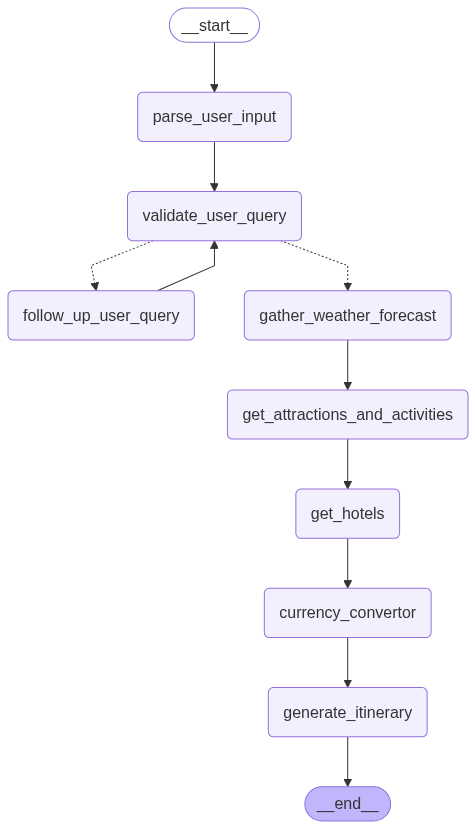

In [76]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
state = TravelAgentState(user_query=["I want to go to Goa from tomorrow from Mumbai for a week. I want to stay at hotel and eat at restaurants. I want to visit all the possible places and enjoy. My budget is 2 Lakhs."])
final_state = graph.invoke(state)

Exchange rate not set. Cannot perform currency conversion.
  "hotel_summary": "Welcome to The Postcard Inn, Candolim! This charming hotel, located in the hea...


/var/folders/_r/5tgc_pmx6z36cqlgkrdf1k_r0000gr/T/ipykernel_1069/1308578468.py:136: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  state.travel_plan_output = itinerary.dict()


In [78]:
import pprint
pprint.pprint(final_state)

{'activities': [{'date': '2025-06-19',
                 'description': 'Learn to prepare traditional Goan dishes, '
                                'including seafood curries and vindaloo, from '
                                'a local chef.',
                 'duration_hours': 3,
                 'location': 'Panjim (various locations)',
                 'name': 'Goan Cooking Class'},
                {'date': '2025-06-23',
                 'description': 'Take a guided tour of a spice plantation, '
                                'learn about different spices, and enjoy a '
                                'traditional Goan lunch.',
                 'duration_hours': 3,
                 'location': 'Ponda',
                 'name': 'Spice Plantation Tour'},
                {'date': '2025-06-24',
                 'description': 'Enjoy a peaceful kayaking experience in the '
                                'backwaters of the Mandovi River, observing '
                                'th

In [79]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
import markdown

def convert_markdown_to_pdf(markdown_string, output_filename="itinerary_2.pdf"):
    """
    Converts a markdown string to a PDF document.

    Args:
        markdown_string (str): The input string in markdown format.
        output_filename (str): The name of the output PDF file.
    """
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    html = markdown.markdown(markdown_string)

    for line in html.split('\n'):
        if line.strip().startswith('<h2'):
            text = line.replace('<h2>', '').replace('</h2>', '').strip()
            story.append(Paragraph(text, styles['h2']))
            story.append(Spacer(1, 0.2 * 1.5 * 10)) # Add some space after heading
        elif line.strip() and not line.startswith('<p>') and not line.startswith('</p>'):
            # This handles text lines not wrapped in <p> tags if they exist
            story.append(Paragraph(line.strip(), styles['Normal']))
            story.append(Spacer(1, 0.1 * 10))
        elif line.strip().startswith('<p>'):
            text = line.replace('<p>', '').replace('</p>', '').strip()
            if text: # Only add if there's actual text
                story.append(Paragraph(text, styles['Normal']))
                story.append(Spacer(1, 0.1 * 10)) # Small space between paragraphs


    doc.build(story)
    print(f"PDF '{output_filename}' created successfully!")

In [80]:
import pprint

markdown_text = pprint.pformat(final_state['full_itinerary'], width=120)
clean_md = eval(markdown_text)


convert_markdown_to_pdf(clean_md)

PDF 'itinerary_2.pdf' created successfully!
